In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.io.wavfile
from scipy.fftpack import fft, fftfreq
from scipy.fftpack import dct
from scipy.signal import get_window
import scipy.fftpack as fft
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display

### INTRODUCTION
 
As we now, especially for machine learning, managable and compressed datasets for research make the proccess easier to implementation, reduce storage space. So for developers, main task is to reduce database with minimal errors without losing any important or relevant data. Nowdays speech recognition or any other type of speech system is very important. 
There are many techniques for keeping signal information while reduce the dimension. Mel-frequency Cepstrum Coefficient is designed to model features of audio signal and is widely used in various fields. 
 
Description From Wikipedia:  
"In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency."
 
### Steps for implementation:
 
For feature extraction, Mel Frequency Cepstrum Coefficient (MFCC) is capable to extract harmonics and sidebands of the spectrum version of the signal in some period of time. MFCCs are composing the MFC. These coefficients are derived form the type of cepstral representation of the audio clip. MFCCs provide a compact representation of the audio signal that captures the important features related to human hearing. These features can then be used in applications like speech recognition.
 
The difference in MFC is that, as we know humans can hear between some determined frequencies in non-linear way. Mel scale is presenting (convert) actual frequency scale to scale in a way human percieve the sounds. 
 
Sound wave is a wave, which can be presented like series of numbers (samples). Samples "sample rates" are measured in Hz, which we can call Frequency. Spectrum sound is the presentation of all frequancies and amplitudes. Amplitude present how intense is the wave in that time. Power of spectrum is telling how much of different frequincies is present in a sound signal at some time. 
 
Cepstrum is helping to investigate and separate the different components of the sound signal. To get the cepstrum, we have to compute the logarithm of the power spectrum (to compress the range of values) and then perform a transformation called the Discrete Cosine Transform (DCT). Actually Cepstrum is just Spectrum over Spectrum.
 
Humans are more sensitive to changes in quiet sounds than in very loud sounds. Taking the logarithm of the power spectrum helps match how humans hear loudness.
 
If we summirize all the information, there are few steps we have to go trough with corresponding equations:
 
1. Pre-emphasis filter: This is high-pass filter which amplify the high frequencies. This is used to increase the magnitude of higher frequency, because their energy is much smaller than the low frequency. This will improve the accuracy of the whole proccess.  $$y(t) = x(t) - \alpha*x(t-1)$$ where $\alpha \in (0.95, 0.97) $ this is the pre-emphasis coefficient, $x(t)$ is the original signal
2. Framing: To get better precisely feaures, we gets sliced the signal into (overlapping) frames. The meaning of this step is that from small period of time we will be able to extract more accurate frecuency components and on this frames to do Fourier transform. This ensures that the characteristics of the signal remain relatively stationary within each frame. If the frames are side by side each other, this will cause loss of frequency. That is why overlap the frames. Usualy that is call hop-size, or hop-length and tell us in how many samples in right is the next frame. After some experiments the acceptable frame length is around 25ms, which is not too long and not too less and the hop could be 10ms.  $$x_{frames}(n) = x(n + mM)$$ $m = 0,1,2,\dots,[\frac{N-L}{M}]$ - cover all possible frames, where $N$ is the signal length, $M$ is the hop size (frame step), $L$ is the length of each frame in the samples; $n$ is in range $(0, L-1)$ and cover lenght of 1 frame
3. Windowing: 
Windowing functions are smooth functions which go to zero at the borders. After slicing we have something like spectrum leaking. By multiplying the input signal with a window function, the windowing function also goes to zero at the border such that the discontinuity at the border becomes invisible. 
Window function is applied to each frame. Used concept is Hamming window, smoothing functions. The hamming window gives accurate information of the original signal's frequency spectrum after sclicing.
Spectral leakage is a phenomenon that occurs when you analyze a signal in the frequency domain using techniques like the Fourier Transform. It arises because the signal you’re analyzing is typically finite in length, and the Fourier Transform assumes an infinite signal. When you apply the Fourier Transform to a finite signal, it’s as if you’re repeating that finite signal infinitely in both directions. This can cause the frequency components near the edges of the signal to “leak” into other frequency bins. In other words, the energy from a frequency component might spread into neighboring frequency bins.It can cause the distortion of the signal.
Tapering, not segmentation, is the main purpose of window functions.
 $$w[n] = 0.54 - 0.46cos(\frac{2\pi n}{N-1})$$ where $0\leq n \leq N-1$, $N$ is the window length.  
5. FFT and Power Spectrum: In this step we do a Fourier transform on each frame (or more specifically a Short-Time Fourier Transform) and calculate the power spectrum. Fast Fourier Transform is most useful algorithm for speech analyses. It convert time domain to frquency domain. Because we want to capture precise information for each frequency, we compute FFT on each window. So, basicly we apply Discrete Fourier Transform, which is а way to present Fourier analys. And we receive time frequency amplitude for each frame. The output is complex number, which consist real and imaginary part. Usually $N$ is signal of each frame. The equation for FFT is $$X(k) = \sum_{n=0}^{N-1}x_{w}(n)e^{-j\frac{2\pi kn}{N}}$$ where we receive sequence of complex numbers $X(k) = X_0,X_1,\dots,X_{N-1} \\$ Power Spectrum on the other hand give us information for the energy of every frequency component of the sound. This is called the Periodogram estimate of the power spectrum. We take the absolute value of the complex fourier transform, and square the result.  With power we measure , how much energy we have in the frequency.  the equation for computing Power Spectrum is: $$P(k) = \frac{|X(k)^2|}{N}$$ $k = 1,\dots K$, $K$ is the length of DFT (number of discrete Fourier transformation coefficients) and is usually 512. If we have 44100 sample rate, 1 sample is equal to 0.0227 ms. Human ear's time resolution is 10ms, so  cannot percept sound less than that. That means frame, or samples should be bigger than 441. So 512, which is power of 2, one of the reasons for better efficiant computation of FFT is closest number. 
6. Mel Filterbank: We convert the power spectrum of the signal from a linear frequency scale to a Mel frequency scale. The Mel scale approximates the human ear's response more closely than the linear scale. This filter gices the energy of each frequancy band. We can think for Mel band like bins, where frequency close to each other are grouped. For each filter, the Mel filter bank calculates the energy of the signal within the frequency range that the filter represents. First Mel band, narrowest, show the power of near 0 Hz and they become more widley with the growth of the frequncy. N $$m = 2595\log_{10}\left (1+\frac{f}{700}\right)$$ After we convert $Mel scale$ to $frequency$: $$f = 700\left(10^{\frac{m}{2595}} -1\right)$$  The prime formula is $m = C*\log{1 + \frac{f}{f_0}}$. In Mel scale below some corner frequency changes are linearly, and above is start to change logarithmically. It is usually between 600 Hz and 1000 Hz. So $f_0$ is this frequency. Constant $C$ is 1, because 1000 Hz = 1000 Mel, so we can calculate $C$ as follows: $ C = \frac{1000}{\log(1 + \frac{1000}{f_0})}$
8. Logarithm: Converts to the logarithmic scale for better dynamic range representation and convert FFT complex numbers to value. The logarithm of the filterbank energies is taken to compress the dynamic range of the values and to mimic the non-linear response of the human ear to sound intensity. $$f_{mel} = log\sum{P(k).H_m(k)}$$ where $$\begin{align*} H_{m}\left ({k }\right)=\begin{cases} \displaystyle 0 & k < f\left ({m-1 }\right)\\ \displaystyle \frac {k-f\left ({m-1 }\right)}{f\left ({m }\right)-f\left ({m-1 }\right)} & f\left ({m-1 }\right)\le k < f\left ({m }\right)\\  \displaystyle \frac {f\left ({m+1 }\right)-k}{f\left ({m+1 }\right)-f(m)} & f\left ({m }\right) < k\le f\left ({m+1 }\right)\\ \displaystyle 0 & k>f(m+1) \end{cases}\!\!\!\! \\{}\tag{2}\end{align*}$$
9. Discrete Cosine Transform (DCT) retaining a number of the resulting coefficients while the rest are discarded. On this step we decorrelate the log filterbank energies and pack the most significant information into the smallest number of coefficients. It is sum of cosine functions of different frequencies and amplitude. Operation is over discrete number of points. DCT is simplify version of Fourier Transfor, which gives back real value coefficients. What DCT is doing is to compute the cosine of different frequencies and to return values, which shows how well this cosine with that frequency fit the original logaritm spectrum. And those values are the MFCCs. Higher cosine is higher Mel coefficient. $$ C_n = \sum_{m=1}^{M}L_m\cos\left[\frac{\pi n\left(2m-1\right)}{2M}\right]$$ where,
$C_n$ - n-th Mel coefficient,
$L_m$ is the m-th Logarithm from step 6,
$M$ is Mel filters number
MFCCs are giving us a knowledge of the spectrum, providing us information about the phonems. They have huge performance in Machine Learning and work well in many applications.

### Applications
 
Cepstrum Coefficient (MFCC) is a framework feature extraction technique that has been adopted in many areas and frequently reported to be useful for various applications in many fields. 
<!-- ```                -->
$\bf 1. Acoustic Analysis $ $\\$
    $\quad$1.1 Speech Analysis 
    Speech signal analysis aims to find out more informative, compact, and relevant knowledge than the speech signal raw data itself. Vocal tract features (also named as segmental, spectral or system features) are one of the well-known representations of speech analysis. When the process of speaking starts, the air is traveling out from the lungs, the air movements within the vocal tract create a unique version of the sound. Vocal tract features are well reflected in the frequency domain of the speech signal. There are various developed techniques to extract vocal tract features, one of which is the MFCC. The MFCC can capture the vocal tract features, since it extracts human ear information, which has a response of a non-linear scale instead of a linear scale . Among the most well-known applications that utilize MFCC of the speech signal are emotion recognition in speech, language and dialect recognition and speech recognition as shown in the following subsections.$\\$
           $\qquad$ 1.1.1 Automatic Speech Recognition $\\$
        The ASR model targets the recognition of four main categories, which are isolated word, connected word, continuous speech, and spontaneous speech. The MFCC feature is one of the well-known features especially for isolated word speech recognition for instance the MFCC feature was extracted from speech signals of spoken words (isolated) and then classified via Support Vector Machine (SVM) and Maximum Likelihood Classifier. $\\$
             $\qquad$1.1.2 Speech Emotion Recognition $\\$
        Speech Emotion Recognition (SER) is the process of identifying the emotion of the human from the speech signal. Based on the existing literature, it is well understood that MFCC features for SER can reach a high recognition rate compared to other cepstrum features because it is a short-term spectral based feature that leads to extract a rich amount of information from speech signals.  $\\$
             $\qquad$1.1.3 Language and Dialect Recognition $\\$
        Language recognition system aims to recognize the language of the speaker, which can be developed based on the machine learning model. Dialect recognition is quite like language recognition. However, the dialect recognition focuses on categorizing the dialects or accents rather than categorizing the languages and consequently, more challenging due to the linguistic similarities among dialects. Dialect recognition is an important application, and it has been considered as one of the very first steps to speech recognition.
    $\quad$ 1.2 Biometric Application $\\$
    Biometric application is an application which allows to either confirm or determine the identity of a certain characteristic of an individual. The aim of these applications is to confirm that the provided services are accessed only by a legitimate user. Biometric applications can be classified into two categories speaker recognition and gender recognition, where MFCC has been used.$\\$
             $\qquad$1.2.1 Speaker Recognition $\\$
        Speaker recognition is the process of automatically recognizing the speaker based on their speech signal and can be classified into six categories such as speaker identification, speaker verification, speaker detection, speaker segmentation, speaker clustering and speaker diarylation. Speech signals contain speaker-specific information which can be extracted and fed to a machine learning algorithm to learn a specific pattern in it. MFCC and LPC (Linear Predictive Codes) are considered as the most two well-known features that have been widely used by researchers for speaker recognition applications, due to their capacity to capture the repetitive nature and efficiency of speech signals.
            $\qquad$ 1.2.2 Gender Recognition Over the Phone Call $\\$
        Gender recognition is the process of identifying a speaker’s gender via analysis and comparison of patterns. Gender recognition is one of the effective techniques for biometric and has been a widely interested application for forensic teams. The most Common feature for gender recognition is the pitch feature of the speech. For example, MFCC features were merged with the speaker’s mean pitch for gender recognition.  $\\$
     $\quad$ 1.3. Digital Forensic $\\$
    Digital forensic can be defined as an application or a process which helps the forensic team to identify, analyze and extract important information regarding a specific crime or fakes from digital data. Usually, it is considered as robust evidence in court of law. Digital forensic applications vary depending on obtained information such as Network information and personal information about criminals.$\\$
            $\qquad$ 1.3.1 Sentiment Speech Analysis $\\$
        Sentiment speech detection is the analysis of the speech signal to extract subjective information in source material for identifying the mood of the speaker and customer that helps a business understand the social sentiment of their product and service during the monitoring of online chats.$\\$
           $\qquad$  1.3.2 Fake Speech Detection $\\$
        Although many recent technologies have been developed for voice recognition speaker verification, it still struggles and opens issues which is having a universal fake speech and it needs to be detected. The main aim of fake speech detection is to differentiate between a fake speech and a natural speech. There are plenty of features that have been used for detecting fake speech such as MFCC and LPC.$\\$
 
$\bf 2. Medical Applications $ $\\$
    $\quad$ 2.1 EEG Analysis $\\$
    $\quad$ 2.2 ECG Analysis $\\$
    $\quad$ 2.3 Disease Detection Application $\\$
   
$\bf 3. Industry Analysis$ $\\$
   Reliability of machines or tools is gaining importance in the industry because of the need to decrease the possible loss of production whenever the machine experiences an abnormal situation during the working load. 
    $\quad$ 3.1 Gear Health Monitoring $\\$
    $\quad$ 3.2 Bearing Health Monitoring $\\$
   $\quad$  3.3 Turbine Health Monitoring $\\$
    $\quad$ 3.4 Pump Health Monitoring $\\$
<!-- ``` -->
 
### References

1. https://ieeexplore.ieee.org/document/9955539
2. https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
3. https://blog.lambdaconcept.com/post/2021-05/fpga-mel-frequency-cepstrum/
4. https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
5. https://en.wikipedia.org/wiki/Cepstrum
6. https://stackoverflow.com/questions/5418951/what-is-the-hamming-window-for
7. https://www.youtube.com/watch?v=hF72sY70_IQ
8. https://www.youtube.com/watch?v=8A-W1xk7qs8&t=754s
9. http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/#computing-the-mel-filterbank
10. https://dsp.stackexchange.com/questions/46209/the-origin-of-constants-in-mel-scale-formula

### MFCCs implementation

In [3]:
def load_signal(signal):
    samplerate, audio = scipy.io.wavfile.read(signal) 
    return samplerate, audio 
    
def pre_emphasis(audio, alpha):
    return np.append(audio[0], audio[1:] - alpha * audio[:-1])

samplerate, audio = load_signal("c-note.wav")
t  = np.linspace(0, len(audio)/samplerate, len(audio))

frame_length = 0.025
frame_step = 0.01
numbers_filters = 26
fft_coeff = 512
a  = 0.97
signal_emphasis = pre_emphasis(audio,a)

C:\Users\nushi\AppData\Local\Temp\ipykernel_17676\1618512468.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, audio = scipy.io.wavfile.read(signal)


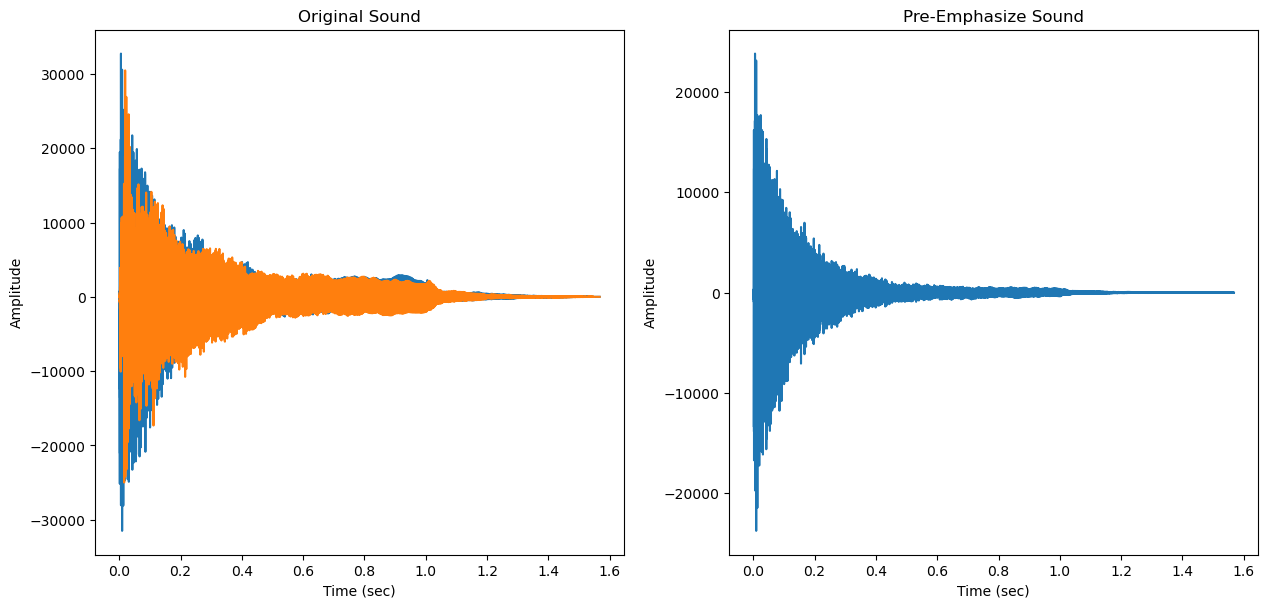

In [4]:
time = np.linspace(0, (len(signal_emphasis)/samplerate)/2, len(signal_emphasis))
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(t, audio)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.title("Original Sound")
plt.subplot(222)
plt.plot(time, signal_emphasis)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.title("Pre-Emphasize Sound")
plt.show()

In [5]:

def audio_frames(audio, sample_rate, frame_length, frame_step):    
    signal_length = len(audio)
    frame_samples_length = np.floor(frame_length * sample_rate )
    frames_step_samples_length = np.floor(frame_step * sample_rate)
    num_frames = np.floor((signal_length - frame_samples_length)/frames_step_samples_length) + 1 # +one frame left last without step
 
    n = np.array([np.arange(0, int(frame_samples_length),dtype='int64') for i in np.arange(0, int(num_frames),dtype='int64')]) # all samples/frame for every frame
    m_M = np.array([(np.arange(0, int(num_frames),dtype='int64'))*int(frames_step_samples_length) for i in np.arange(0, int(frame_samples_length),dtype='int64')]).T # from equation m*M for every frame, array should be transformed, this is 
    all_frames_x = n + m_M

    length_diff = int(num_frames * frames_step_samples_length + frame_samples_length) - signal_length
    zeros_padding = np.zeros(length_diff)
    new_audio = np.append(audio, zeros_padding)   #if we don't have equal length we add zeros in the end. This is because each frame overlap with frame_step
    audio_frames = new_audio[all_frames_x] # the audio sliced on segments/frames    

    return audio_frames

def window_frames(framed_audio, frame_length):    
    i = np.linspace(0,int(frame_length-1), int(frame_length))    
    hamm_w = ([0.54 - 0.46*np.cos((np.pi*2*i)/(frame_length-1)) ])
    audio_framed_window = framed_audio * hamm_w  #hamming window (vector) multiply by each frame
    return audio_framed_window

# Hamming window with numpy
def hamm_win(frame_length):
    return np.hamming(frame_length)


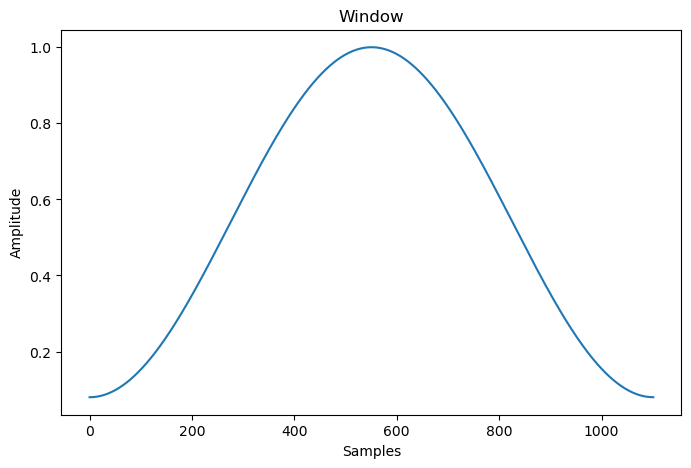

In [6]:
frame_audio_custom = audio_frames(signal_emphasis, samplerate, frame_length, frame_step)

windowing_frames = window_frames(frame_audio_custom, frame_length * samplerate)
ham = hamm_win(frame_length*samplerate)

plt.figure(figsize = (8,5))
plt.plot(ham)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Window")
plt.show()

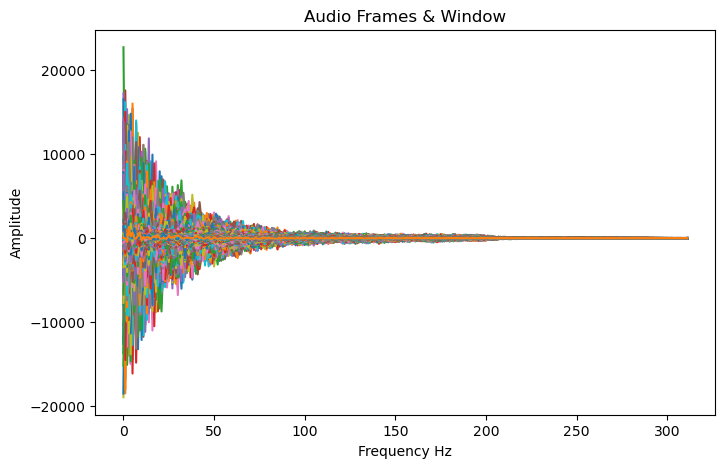

In [7]:
plt.figure(figsize = (8,5))
plt.plot(windowing_frames)
plt.xlabel("Frequency Hz")
plt.ylabel("Amplitude")
plt.title("Audio Frames & Window")
plt.show()

In [8]:
def fft_ps_compute(frames, nfft, frame_length):
    c = 1/frame_length
    sftf = np.absolute(np.fft.rfft(frames, nfft))**2
    return sftf * c

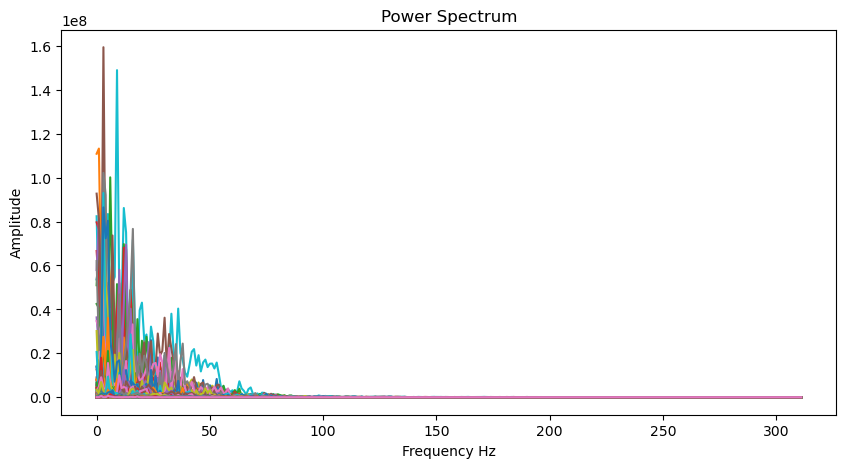

In [9]:
power_fft = fft_ps_compute(windowing_frames, fft_coeff, frame_length * samplerate)

plt.figure(figsize=(10,5))
plt.xlabel("Frequency Hz")
plt.ylabel("Amplitude")
plt.title("Power Spectrum")
plt.plot(power_fft)
plt.show()

In [10]:
def h_mel_transform_filters(samplerate, numbers_filters): # convert Hz to Mel and divide on the triangularers Mel filters, usually they are 26 filters
    mels = np.linspace(0, 2595*np.log10(1+ (samplerate/2)/700), (numbers_filters+2)) # low frequency = 0, high - samplerates/2 num fil +2
    return mels
 
def mel_frequency_convert(mels): # convert again Mel to Hz 
    frequency_mel = (700 * (10**(mels/2595) - 1))
    return frequency_mel
 
def mel_filterbanks(numbers_filters, frequency_mel, power_spectrum, samplerate, fft_coeff):    
    f_bins = (np.floor(((fft_coeff+1)*frequency_mel)/samplerate))
    len_fft = int(fft_coeff/2 +1)
    mel_filters = np.zeros((numbers_filters, len_fft))
 
    for m in np.arange(1, numbers_filters+1):        
        for k in np.arange(int(f_bins[m-1]), int(f_bins[m])):
            mel_filters[m-1,k] = ((k - f_bins[m-1])/(f_bins[m]-f_bins[m-1]))    
        for k in np.arange( int(f_bins[m]), int(f_bins[m+1])+1):
            mel_filters[m-1,k] = ((f_bins[m+1]-k)/(f_bins[m+1] - f_bins[m]))

    mel_filters = np.transpose(mel_filters)
    return mel_filters
 
def logairtm_filt(mel_filters, power_spectrum):
    EPS = 1e-10
    matrix = np.dot(power_spectrum, mel_filters)
    logaritm = np.where(matrix != 0, np.log10(matrix), EPS)  
    return logaritm

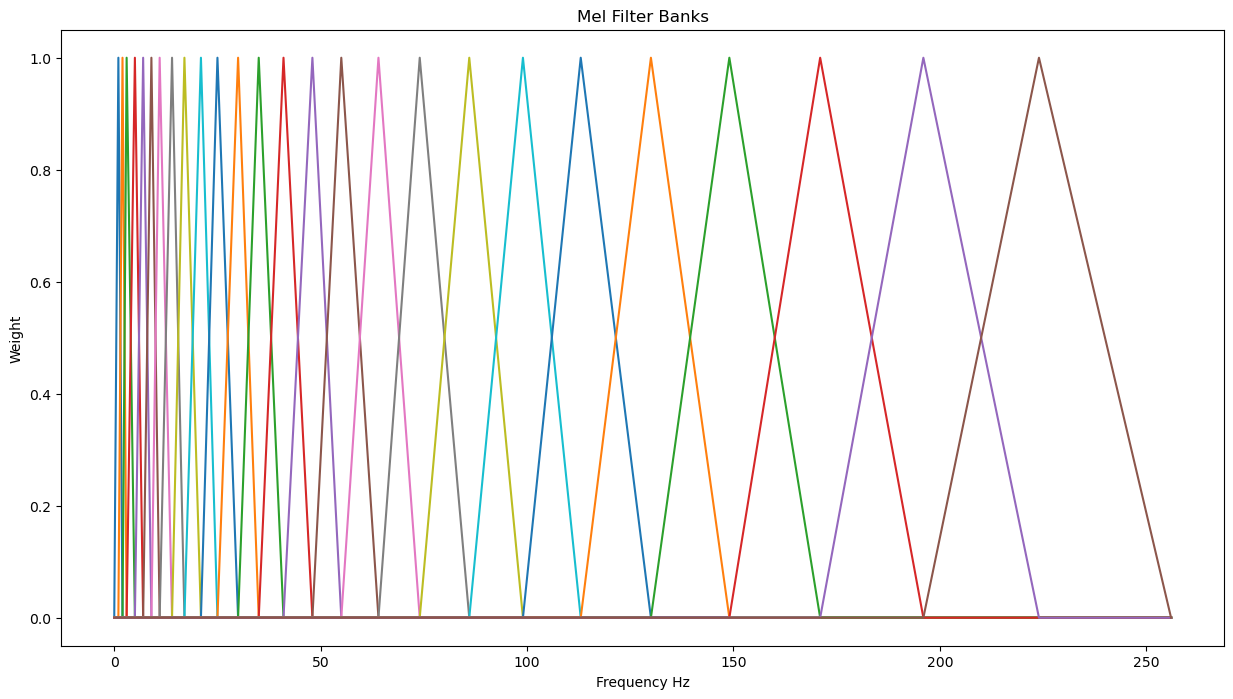

In [11]:
mel_transform = h_mel_transform_filters(samplerate, numbers_filters)
mel_to_frequency = mel_frequency_convert(mel_transform)
mel_banks = mel_filterbanks(numbers_filters, mel_to_frequency, power_fft, samplerate, fft_coeff)
logairtm_mb = logairtm_filt(mel_banks ,power_fft)
plt.figure(figsize=(15, 8))
plt.plot(mel_banks)
plt.xlabel("Frequency Hz")
plt.ylabel("Weight")
plt.title("Mel Filter Banks")
plt.show()

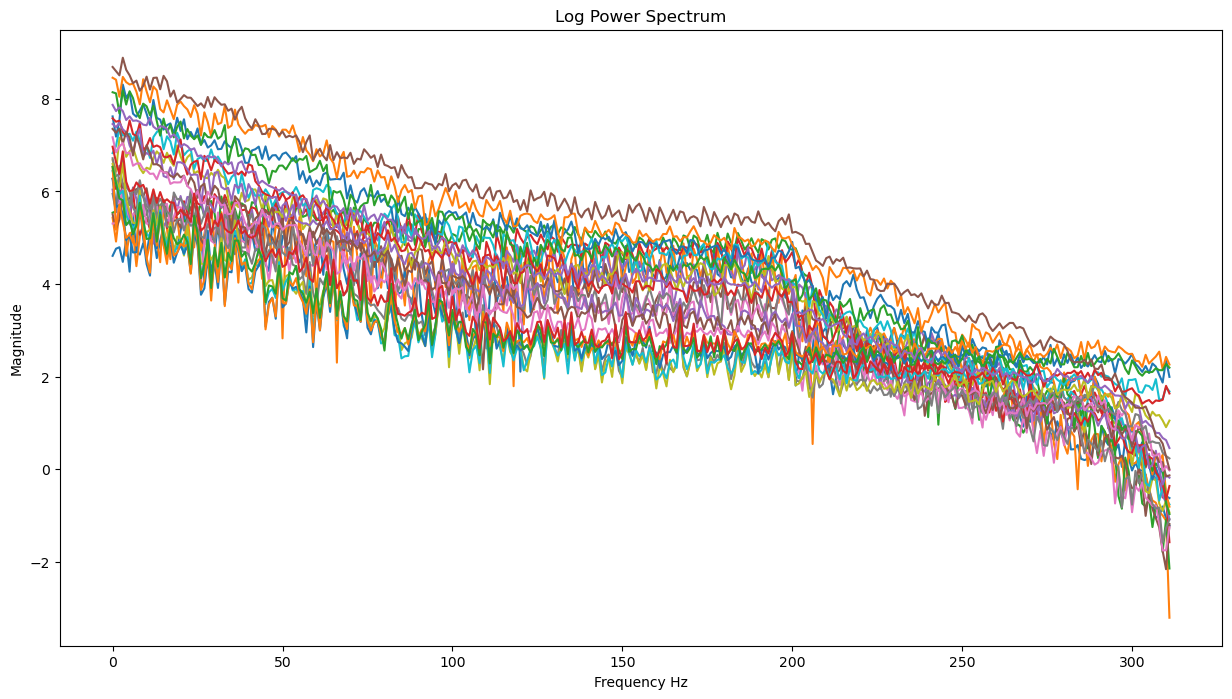

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(logairtm_mb)
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude dB")
plt.title("Log Power Spectrum")
plt.show()

In [26]:
def compute_mfcc(logairtm, num_ceps=13):
    mfcc = dct(logairtm, type=2, axis=1, norm='ortho')[:, :num_ceps].T
    return mfcc

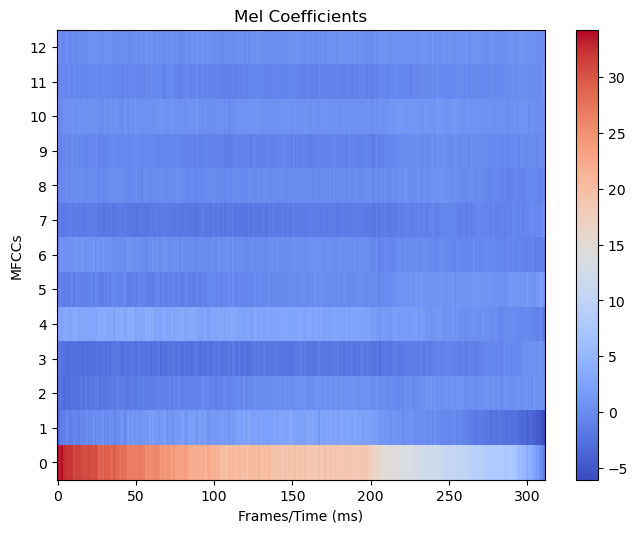

In [27]:
mel_check = compute_mfcc(logairtm_mb)
plt.figure()
librosa.display.specshow(mel_check)
plt.colorbar()
plt.tight_layout()
plt.title("Mel Coefficients")
plt.ylabel("MFCCs")
plt.xlabel("Frames/Time (ms)")
plt.yticks(range(0, len(mel_check)))
plt.xticks(range(0,mel_check.shape[1],50))
plt.show()